In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import pickle
import sys
import yaml

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, TimeDistributed, Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.utils import plot_model
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import load_model
from sklearn import preprocessing
from copy import deepcopy

import datetime
import math
import hashlib
import time
import os
from datagenerator import DataGenerator

# add
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"  # specify which GPU(s) to be used

Using TensorFlow backend.


In [2]:
#Disable randomization
import random
seed_value=2020 #10 #
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
random.seed(seed_value)

# add
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True 
# # sess = tf.Session(config=config) 
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [3]:
def loadConfig():
#     with open('/home/wesleyjtann/ddos_research/test/light_config_b.yaml', "r") as ymlfile:
    with open('./light_config_hulk.yaml', "r") as ymlfile: #hulk, slowloris; GE, heartbleed, slowhttp
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()
# artefact = 'artefact' #'artefact_b' #

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


## Helper functions

In [4]:
def prepare_sentence(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqY = np.append(seq, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    y= pad_sequences([seqY],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    return [x], [y]


def getTokenizer(df) :
    ### Dictionary for Normal ###
    tokenizer = Tokenizer(filters='', split='<sep>', oov_token='<OTHERS>' ,lower=True)
    tokenizer.fit_on_texts(df['Input'].values)

    tokenizer.fit_on_texts(['<SOS>'])
    tokenizer.fit_on_texts(['<EOS>'])

    return tokenizer

# def createGeneratorData(df, tokenizer, max_len) :
#     #Prepare training for normal model
#     x = []
#     y = []

#     for seq in df['Input']:
#         x_windows, y_windows = prepare_sentence(seq, max_len, tokenizer)
#         x += x_windows
#         y += y_windows
#     x = np.array(x)
#     y = np.array(y)  # The word <PAD> does not constitute a class

#     x.shape = [len(x), max_len + 1, 1]
#     y.shape = [len(y), max_len + 1, 1]

#     return x, y

def prepare_sentence_classification(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
#     seqX = np.append(seq, tokenizer.word_index['<eos>'])
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqX = np.append(seqX, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+2,
        padding='post')[0]  # Pads before each sequence

    return [x]


def create_input_data(df, tokenizer, max_len):
    #Prepare training for normal model
    x=[]; y=[]
    for index, row in df.iterrows():
        x_windows = prepare_sentence_classification(row['Input'], max_len, tokenizer)
#         y_labels = row['Label']
        y_labels = row['Attack']
#         x += x_windows
        x.append(x_windows)
        y.append(y_labels)
        
    x = np.array(x)
    y = np.array(y)
#     x.shape = [len(x), max_len+2, 1]
    x = np.reshape(x, (len(x), (max_len+2)))#, 1))

    return x, y

## Loading CIC Wed dataset

In [5]:
config['metadata']['artefact']
# config['metadata']['artefact'] = 'artefact_seqlen200hash750'
# config['metadata']['artefact']

'artefact_hulk'

##### Training set

In [6]:
# N1 data
df_normal = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'N1.csv')
print("size of normal data: ", len(df_normal))
# df_normal.head()

size of normal data:  31374


In [7]:
# Entire train atk set. 
df_attackfull = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_full.csv')
print("size of full attack data: ", len(df_attackfull))

size of full attack data:  21987


In [8]:
# make attack 80% of train data 
ratio = 0.5 #0.8 #0.2
df_attacksmall = df_attackfull[-int(len(df_normal)/ratio - len(df_normal)):]
print("size of smaller attack data: ", len(df_attacksmall))

size of smaller attack data:  21987


In [9]:
# for GE, slowloris
df_normal = df_normal[-int(len(df_attacksmall)):]
print("size of normal data: ", len(df_normal))

size of normal data:  21987


In [10]:
# add AGT labels for evaluation
df_normal['Attack'] = 0
# df_attacksmall['Attack'] = 1

attacker='172.16.0.1'; victim='192.168.10.50'
df_attacksmall['Attack'] = 0
# if IP == attacker or IP == victim
df_attacksmall.loc[df_attacksmall['Source IP']==attacker, 'Attack'] = 1
df_attacksmall.loc[df_attacksmall['Source IP']==victim, 'Attack'] = 1
# print("df_attacksmall value counts: \n", (df_attacksmall['Attack']).value_counts())

# Join and shuffle train attack and normal data
df_train = df_normal.append(df_attacksmall).sample(frac=1, replace=False, random_state=39).reset_index(drop=True)
print("size of df_train: ", len(df_train))
print("df_train value counts: \n", (df_train['Attack']).value_counts())

size of df_train:  43974
df_train value counts: 
 0    27270
1    16704
Name: Attack, dtype: int64


/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
numtrain_atk = df_train['Attack'].values.sum()  # True
numtrain_atk

numtrain_norm = len(df_train) - df_train['Attack'].sum()  
numtrain_norm

# count atk percentage in test set
# num_norm, num_atk = (df_test['Attack']).value_counts()

print("Length of test data: ", len(df_train))
print("Number of normal traffic: ", numtrain_norm)
print("Number of true attacks: ", numtrain_atk)
print("Percent attacks: ", numtrain_atk / len(df_train))

Length of test data:  43974
Number of normal traffic:  27270
Number of true attacks:  16704
Percent attacks:  0.3798608268522309


##### Test set

In [12]:
# Load test set
df_test = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'TEST.csv')
print("size of df_test: ", len(df_test))

size of df_test:  11710


In [13]:
# Add labels to test set
attacker='172.16.0.1'; victim='192.168.10.50'
df_test['Attack'] = 0

# if IP == attacker or IP == victim
df_test.loc[df_test['Source IP']==attacker, 'Attack'] = 1
df_test.loc[df_test['Source IP']==victim, 'Attack'] = 1

df_test = df_test.sample(frac=1, random_state=39, replace=False)

In [14]:
(df_test['Attack']).value_counts()

1    7158
0    4552
Name: Attack, dtype: int64

In [15]:
num_atk = df_test['Attack'].values.sum()  # True
num_atk

7158

In [16]:
num_norm = len(df_test) - df_test['Attack'].sum()  
num_norm

4552

In [17]:
# count atk percentage in test set
# num_norm, num_atk = (df_test['Attack']).value_counts()

print("Length of test data: ", len(df_test))
print("Number of normal traffic: ", num_norm)
print("Number of true attacks: ", num_atk)
print("Percent attacks: ", num_atk / len(df_test))

Length of test data:  11710
Number of normal traffic:  4552
Number of true attacks:  7158
Percent attacks:  0.611272416737831


### Prepare data

In [18]:
max_len = config['SEQUENCELENGTH']

tokenizer = getTokenizer(df_train)  

In [19]:
def prep_modelinputs(df, max_len, tokenizer):
    df_embedded = df.copy()
    df_embedded['Input'] = tokenizer.texts_to_sequences(df['Input'].values)
    # Shuffle the data order
    df_embedded_shuf = df_embedded.sample(frac=1, random_state=42, replace=False)
    # Extract inputs and labels
    X_tmp, y_tmp = create_input_data(df_embedded_shuf, tokenizer, max_len)
    # Convert format for training  
    y_tmp = to_categorical(y_tmp, num_classes=2)
    return X_tmp, y_tmp

In [20]:
X_norm, y_norm = prep_modelinputs(df_normal, max_len, tokenizer)
print(X_norm.shape, y_norm.shape)

(21987, 92) (21987, 2)


In [21]:
X_train, y_train = prep_modelinputs(df_train, max_len, tokenizer)
print(X_train.shape, y_train.shape)

(43974, 92) (43974, 2)


In [22]:
X_test, y_test = prep_modelinputs(df_test, max_len, tokenizer)
print(X_test.shape, y_test.shape)

(11710, 92) (11710, 2)


In [23]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print("Training set, counts of label '0': {}".format(int(np.sum(y_train, axis=0)[0])))
print("Training set, counts of label '1': {}".format(int(np.sum(y_train, axis=0)[1])))
print("Test set, counts of label '0': {}".format(int(np.sum(y_test, axis=0)[0])))
print("Test set, counts of label '1': {}".format(int(np.sum(y_test, axis=0)[1])))

Number transactions X_train dataset:  (43974, 92)
Number transactions y_train dataset:  (43974, 2)
Number transactions X_test dataset:  (11710, 92)
Number transactions y_test dataset:  (11710, 2)
Training set, counts of label '0': 27270
Training set, counts of label '1': 16704
Test set, counts of label '0': 4552
Test set, counts of label '1': 7158


### Model

In [24]:
vocab_size=[len(tokenizer.word_index)] 
input_emb_dim = config['MODELPARAMS']['INPUT_EMBED_DIM'] #512
lstm_emb_dim = config['MODELPARAMS']['LSTM_DIM'] #300
print("vocab_size: ", vocab_size)

vocab_size:  [758]


In [25]:
model = Sequential()
model.add(Embedding(vocab_size[0] + 1, input_emb_dim, input_length=X_train.shape[1]))
model.add(LSTM(lstm_emb_dim, return_sequences=True)) # dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(lstm_emb_dim))
# model.add(TimeDistributed(Dense(2, activation='sigmoid')))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer=optimizers.adam(lr=0.005), 
              loss='binary_crossentropy', metrics=['acc']) #lr=0.005 config['MODELPARAMS']['LEARNING_RATE_P']

print(model.summary())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 92, 512)           388608    
_________________________________________________________________
lstm_1 (LSTM)                (None, 92, 300)           975600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 602       
Total params: 2,086,010
Trainable params: 2,086,010
Non-trainable params: 0
_________________________________________________________________
None


## Full classifier training

In [35]:
history = model.fit(X_train, y_train, epochs=20, 
                      batch_size=config['TRAININGPARAMS']['BATCH_SIZE'], validation_split=0.3, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=7, 
                                               mode='auto', min_delta=0.0002)]) #config['TRAININGPARAMS']['EPOCHS_P']

Train on 30781 samples, validate on 13193 samples
Epoch 1/20
30781/30781 [==============================] - 37s 1ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0148 - val_acc: 0.9975
Epoch 2/20
30781/30781 [==============================] - 37s 1ms/step - loss: 8.8257e-04 - acc: 0.9999 - val_loss: 0.0136 - val_acc: 0.9978
Epoch 3/20
30781/30781 [==============================] - 37s 1ms/step - loss: 7.4109e-04 - acc: 0.9999 - val_loss: 0.0141 - val_acc: 0.9975
Epoch 4/20
30781/30781 [==============================] - 37s 1ms/step - loss: 5.9991e-04 - acc: 0.9999 - val_loss: 0.0148 - val_acc: 0.9973
Epoch 5/20
30781/30781 [==============================] - 37s 1ms/step - loss: 6.1783e-04 - acc: 0.9998 - val_loss: 0.0151 - val_acc: 0.9977
Epoch 6/20
30781/30781 [==============================] - 37s 1ms/step - loss: 5.3390e-04 - acc: 0.9999 - val_loss: 0.0153 - val_acc: 0.9975
Epoch 7/20
30781/30781 [==============================] - 37s 1ms/step - loss: 5.6132e-04 - acc: 0.9999 - va

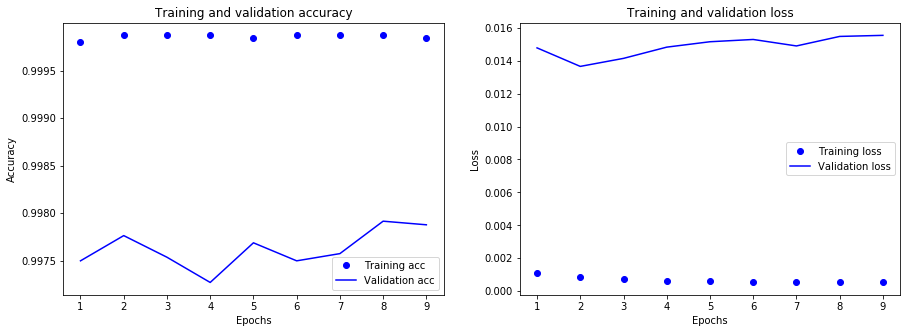

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

f = plt.figure(figsize=(15,5))

ax1 = f.add_subplot(121)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.legend()
ax1.title.set_text('Training and validation accuracy')

ax2 = f.add_subplot(122)
ax2.title.set_text('Generated Synthetic Graph')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.legend()
ax2.title.set_text('Training and validation loss')

plt.show()

### Evaluate Full classifier model

In [37]:
# Extract true labels
ytest_true = np.argmax(y_test, axis=1)

In [38]:
accr = model.evaluate(X_test, y_test, batch_size=512)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

11710/11710 [==============================] - 2s 182us/step
Test set
  Loss: 2.0968
  Accuracy: 0.8046


In [39]:
y_pred = model.predict_classes(X_test, batch_size=512, verbose=1)

11710/11710 [==============================] - 2s 183us/step


In [40]:
y_predscr = model.predict(X_test, batch_size=512, verbose=1)

predpos = np.count_nonzero(y_predscr[:,1] > 0.5)
pred_allpos = predpos / len(y_predscr)
print('Percentage of Positives: {:0.4f}'.format(pred_allpos))

11710/11710 [==============================] - 2s 181us/step
Percentage of Positives: 0.4205


In [41]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy:', accuracy_score(ytest_true, y_pred))
print('Recall:', recall_score(ytest_true, y_pred))
print('Precision:', precision_score(ytest_true, y_pred))
print('F1 score:', f1_score(ytest_true, y_pred))
print('\n clasification report:\n', classification_report(ytest_true, y_pred))
print('\n confusion matrix:\n',confusion_matrix(ytest_true, y_pred))

tn, fp, fn, tp = confusion_matrix(ytest_true, y_pred).ravel()
print(tn, fp, fn, tp)
fpr = fp / (fp+tn)
fpr

Accuracy: 0.8044406490179334
Recall: 0.6841296451522771
Precision: 0.9941128704831507
F1 score: 0.8104932141674943

 clasification report:
               precision    recall  f1-score   support

           0       0.67      0.99      0.80      4552
           1       0.99      0.68      0.81      7158

    accuracy                           0.80     11710
   macro avg       0.83      0.84      0.80     11710
weighted avg       0.87      0.80      0.81     11710


 confusion matrix:
 [[4523   29]
 [2261 4897]]
4523 29 2261 4897


0.0063708260105448155